Klasifikasi menggunakan algoritma Random Forest dalam Keputusan Penerimaan atau Penolakan Pinjaman Kredit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Load Dataset

In [ ]:
application_records = pd.read_csv('/content/drive/MyDrive/uas mining/Dataset/application_record.csv')
pd.set_option('display.max_columns', None)
application_records.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
credit_records = pd.read_csv('/content/drive/MyDrive/uas mining/Dataset/credit_record.csv')
credit_records.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# Explorasi data análisis (EDA)

Data Type

In [ ]:
application_records.info()
credit_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
application_records.shape


(438557, 18)

In [ ]:
credit_records.shape

(1048575, 3)

In [ ]:
application_records = application_records.drop_duplicates(subset = 'ID', keep = False)
application_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438463 non-null  int64  
 1   CODE_GENDER          438463 non-null  object 
 2   FLAG_OWN_CAR         438463 non-null  object 
 3   FLAG_OWN_REALTY      438463 non-null  object 
 4   CNT_CHILDREN         438463 non-null  int64  
 5   AMT_INCOME_TOTAL     438463 non-null  float64
 6   NAME_INCOME_TYPE     438463 non-null  object 
 7   NAME_EDUCATION_TYPE  438463 non-null  object 
 8   NAME_FAMILY_STATUS   438463 non-null  object 
 9   NAME_HOUSING_TYPE    438463 non-null  object 
 10  DAYS_BIRTH           438463 non-null  int64  
 11  DAYS_EMPLOYED        438463 non-null  int64  
 12  FLAG_MOBIL           438463 non-null  int64  
 13  FLAG_WORK_PHONE      438463 non-null  int64  
 14  FLAG_PHONE           438463 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
#show how many unique IDs we will be able to work with in the dataframes
print("# of unique IDs that are consistent between both datasets", application_records[application_records['ID'].isin(credit_records['ID'])]['ID'].nunique())

#adjust the dataframes so that we only work with the consistent IDs
application_records = application_records[application_records['ID'].isin(credit_records['ID'])]
credit_records = credit_records[credit_records['ID'].isin(application_records['ID'])]
print("New # of IDs in application_record", application_records['ID'].nunique())
print("New # of IDs in credit_record", credit_records['ID'].nunique())

# of unique IDs that are consistent between both datasets 36457
New # of IDs in application_record 36457
New # of IDs in credit_record 36457


In [ ]:
application_records = application_records.drop(columns=['CODE_GENDER', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH'])

In [ ]:
#we will mark omited customers with a -1, denied customers with a 0, and approved customers with a 1
def determine_approval(df):
    if(df['STATUS'] == 'X'): return -1
    elif(df['STATUS'] == '1' or df['STATUS'] == '2' or df['STATUS'] == '3' or df['STATUS'] == '4' or df['STATUS'] == '5'): return 0
    elif(df['STATUS'] == 'C' or df['STATUS'] == '0'): return 1

In [ ]:
#create an approved series in df_credit_record
credit_records['APPROVED'] = credit_records.apply(determine_approval, axis=1)
#remove those with an X as a status that we want to omit
credit_records = credit_records[credit_records['APPROVED']!=-1]
credit_records['STATUS'].value_counts()

C    329536
0    290654
1      8747
5      1527
2       801
3       286
4       214
Name: STATUS, dtype: int64

In [ ]:
application_records = application_records.merge(credit_records, on='ID')
application_records.head(10)

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,APPROVED
0,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,0,C,1
1,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-1,C,1
2,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-2,C,1
3,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-3,C,1
4,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-4,C,1
5,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-5,C,1
6,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-6,C,1
7,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-7,C,1
8,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-8,C,1
9,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-9,C,1


In [ ]:
application_records = application_records[application_records['MONTHS_BALANCE']==-4]

In [ ]:
application_records.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,APPROVED
4,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-4,C,1
19,5008805,Y,Y,0,427500.0,Working,Higher education,Rented apartment,-4542,1,1,0,0,NaN,2.0,-4,C,1
33,5008806,Y,Y,0,112500.0,Working,Secondary / secondary special,House / apartment,-1134,1,0,0,0,Security staff,2.0,-4,C,1
49,5008810,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,-3051,1,0,1,1,Sales staff,1.0,-4,C,1
70,5008811,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,-3051,1,0,1,1,Sales staff,1.0,-4,C,1


In [ ]:
application_records.loc[application_records["NAME_INCOME_TYPE"]=="Pensioner","OCCUPATION_TYPE"] = "Pension"
application_records.loc[application_records["NAME_INCOME_TYPE"]=="Commercial associate","OCCUPATION_TYPE"] = "Commercial associate"
application_records.loc[application_records["NAME_INCOME_TYPE"]=="State servant","OCCUPATION_TYPE"] = "State servant"
application_records.loc[application_records["NAME_INCOME_TYPE"]=="Student","OCCUPATION_TYPE"] = "Student"
application_records = application_records.dropna()
application_records.isna().sum()

ID                     0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_HOUSING_TYPE      0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
STATUS                 0
APPROVED               0
dtype: int64

In [ ]:
print(application_records[application_records['DAYS_EMPLOYED'] > 50000].count())
#its impossible for someone to have over 50000 days of employment. Thats over 270 years, so we will drop all these values
application_records = application_records.drop(application_records[application_records['DAYS_EMPLOYED']>100000].index)
application_records = application_records.drop(columns=['STATUS']) #we dont need the status column anymore so we can drop it

ID                     3313
FLAG_OWN_CAR           3313
FLAG_OWN_REALTY        3313
CNT_CHILDREN           3313
AMT_INCOME_TOTAL       3313
NAME_INCOME_TYPE       3313
NAME_EDUCATION_TYPE    3313
NAME_HOUSING_TYPE      3313
DAYS_EMPLOYED          3313
FLAG_MOBIL             3313
FLAG_WORK_PHONE        3313
FLAG_PHONE             3313
FLAG_EMAIL             3313
OCCUPATION_TYPE        3313
CNT_FAM_MEMBERS        3313
MONTHS_BALANCE         3313
STATUS                 3313
APPROVED               3313
dtype: int64


In [ ]:
categorical_columns = application_records.select_dtypes(include=['object']).columns.tolist()
for i in categorical_columns:
    print(f'{i}')
    display(application_records[i].unique())

FLAG_OWN_CAR


array(['Y', 'N'], dtype=object)

FLAG_OWN_REALTY


array(['Y', 'N'], dtype=object)

NAME_INCOME_TYPE


array(['Working', 'Commercial associate', 'State servant', 'Student',
       'Pensioner'], dtype=object)

NAME_EDUCATION_TYPE


array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

NAME_HOUSING_TYPE


array(['House / apartment', 'Rented apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

OCCUPATION_TYPE


array(['Security staff', 'Commercial associate', 'Accountants',
       'Laborers', 'State servant', 'Cleaning staff', 'Drivers',
       'Core staff', 'Sales staff', 'Managers', 'High skill tech staff',
       'Cooking staff', 'Low-skill Laborers', 'Private service staff',
       'Medicine staff', 'Student', 'Waiters/barmen staff', 'Secretaries',
       'HR staff', 'Realty agents', 'IT staff', 'Pension'], dtype=object)

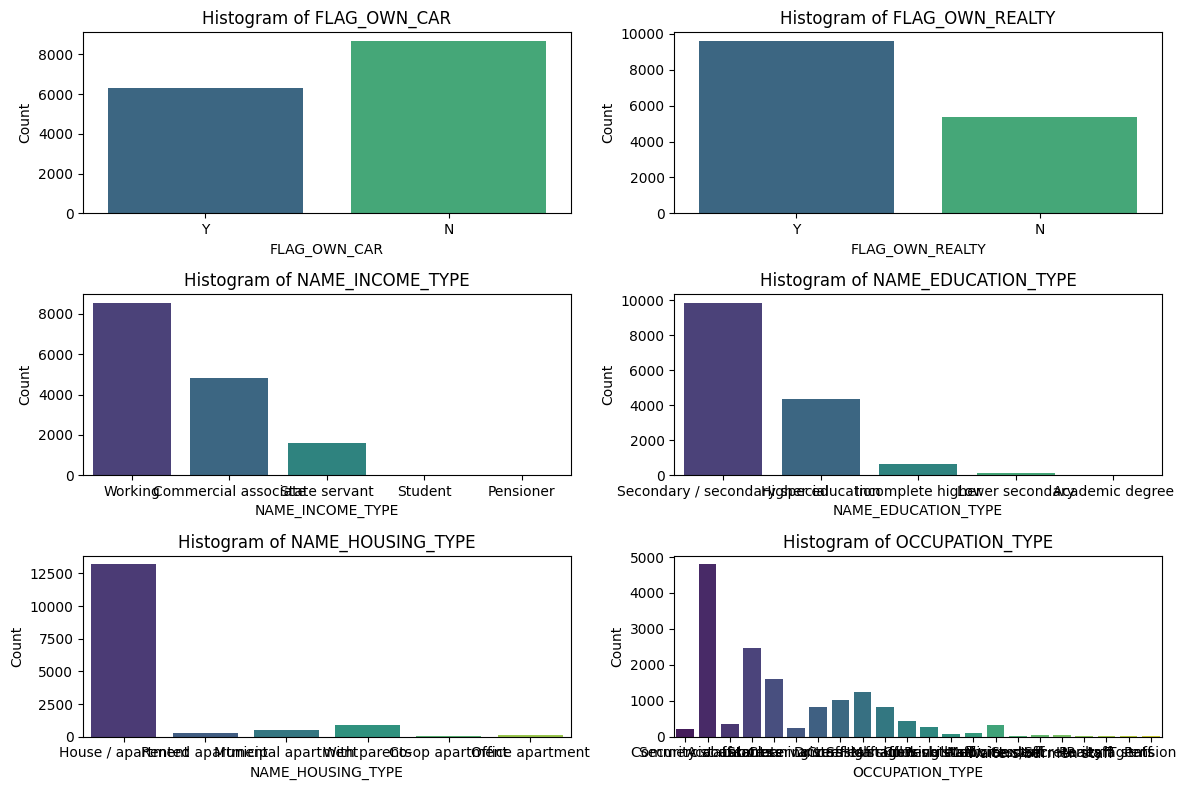

In [ ]:
categorical_columns = application_records.select_dtypes(include=['object'])
# Gabungkan beberapa diagram batang menjadi satu gambar
plt.figure(figsize=(12, 8))

# Loop melalui setiap kolom kategorikal dan buat diagram batang menggunakan Seaborn
for i, column in enumerate(categorical_columns.columns):
    plt.subplot(3, 2, i + 1)
    sns.countplot(x=column, data=categorical_columns, palette='viridis')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Transformasi data

In [ ]:
application_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 33 to 631755
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14993 non-null  int64  
 1   FLAG_OWN_CAR         14993 non-null  object 
 2   FLAG_OWN_REALTY      14993 non-null  object 
 3   CNT_CHILDREN         14993 non-null  int64  
 4   AMT_INCOME_TOTAL     14993 non-null  float64
 5   NAME_INCOME_TYPE     14993 non-null  object 
 6   NAME_EDUCATION_TYPE  14993 non-null  object 
 7   NAME_HOUSING_TYPE    14993 non-null  object 
 8   DAYS_EMPLOYED        14993 non-null  int64  
 9   FLAG_MOBIL           14993 non-null  int64  
 10  FLAG_WORK_PHONE      14993 non-null  int64  
 11  FLAG_PHONE           14993 non-null  int64  
 12  FLAG_EMAIL           14993 non-null  int64  
 13  OCCUPATION_TYPE      14993 non-null  object 
 14  CNT_FAM_MEMBERS      14993 non-null  float64
 15  MONTHS_BALANCE       14993 non-nul

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for column in application_records.select_dtypes(include=['object']).columns:
    application_records[column + '_encoded'] = label_encoder.fit_transform(application_records[column])
# Hapus kolom-kolom objek yang sudah di-Label Encode
application_records = application_records.drop(application_records.select_dtypes(include=['object']).columns, axis=1)
application_records.head()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,APPROVED,FLAG_OWN_CAR_encoded,FLAG_OWN_REALTY_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_HOUSING_TYPE_encoded,OCCUPATION_TYPE_encoded
33,5008806,0,112500.0,-1134,1,0,0,0,2.0,-4,1,1,1,4,4,1,18
49,5008810,0,270000.0,-3051,1,0,1,1,1.0,-4,1,0,1,0,4,1,2
70,5008811,0,270000.0,-3051,1,0,1,1,1.0,-4,1,0,1,0,4,1,2
145,5008815,0,270000.0,-769,1,1,1,1,2.0,-4,1,1,1,4,1,1,0
148,5112956,0,270000.0,-769,1,1,1,1,2.0,-4,1,1,1,4,1,1,0


In [ ]:
application_records = application_records.drop(['FLAG_MOBIL', 'MONTHS_BALANCE'], axis=1)

# Preprocessing Data ( Feature Selection )

Korelasi

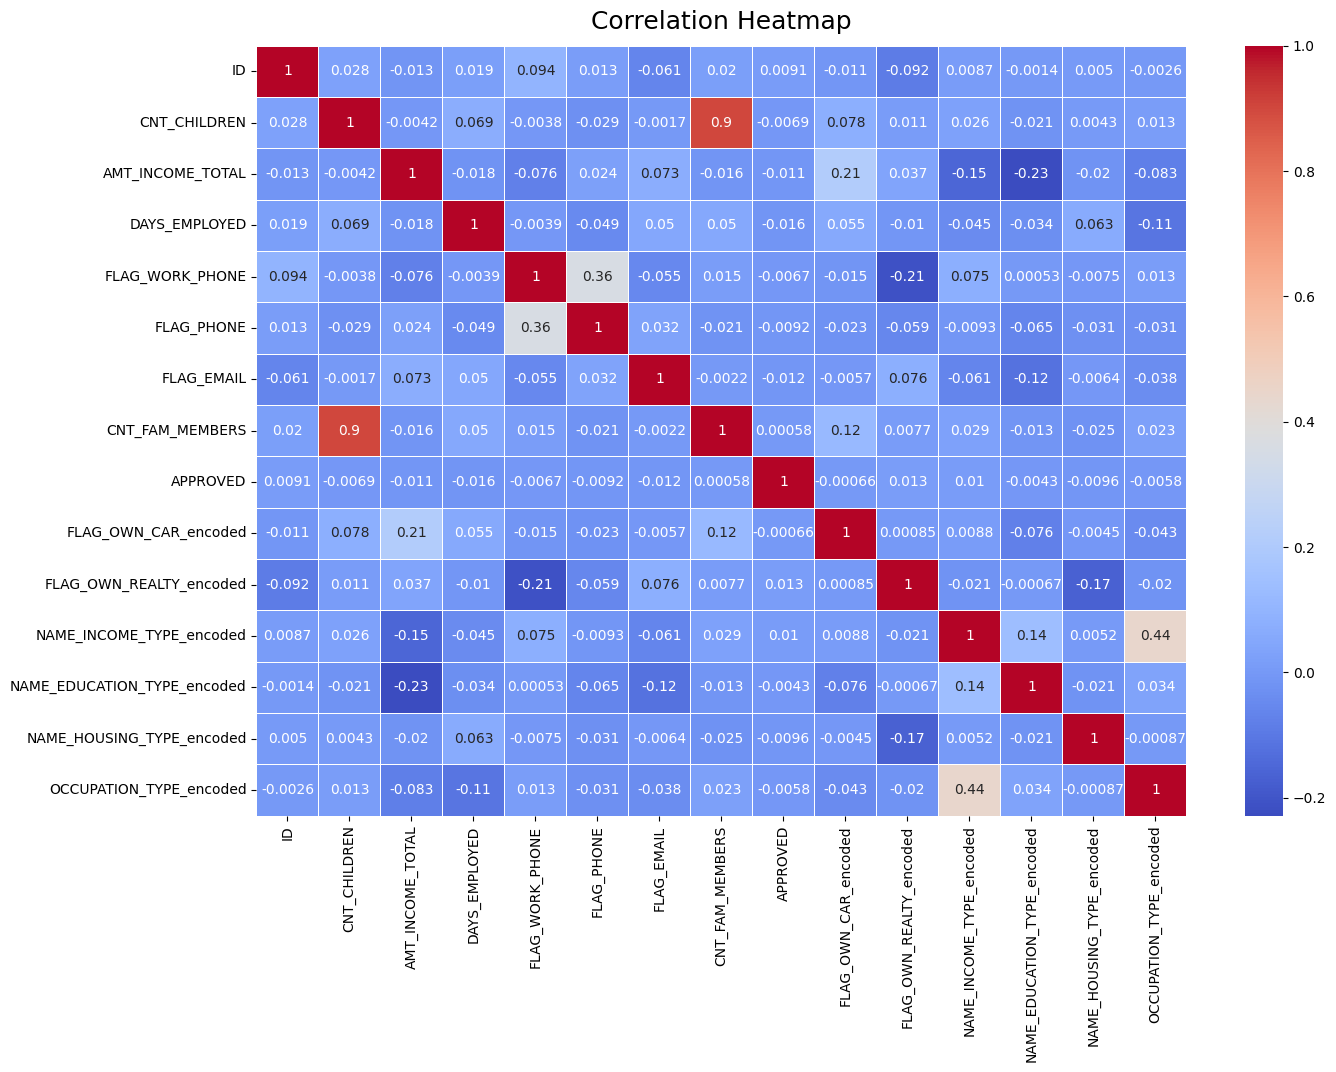

In [ ]:
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(application_records.corr(), annot=True, cmap='coolwarm', linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=12)

plt.show()

# Feature Selection

In [ ]:
X=application_records.drop(['ID', 'APPROVED'], axis='columns')
y=application_records['APPROVED']

# Spliting Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan jumlah data dalam set pelatihan dan set pengujian
print("Jumlah data dalam set pelatihan (X_train, y_train):", X_train.shape[0])
print("Jumlah data dalam set pengujian (X_test, y_test):", X_test.shape[0])

Jumlah data dalam set pelatihan (X_train, y_train): 11994
Jumlah data dalam set pengujian (X_test, y_test): 2999


# Building Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#random forest
model = RandomForestClassifier(n_estimators = 1000, max_features = 12)

model.fit(X_train, y_train)


RandomForestClassifier(max_features=12, n_estimators=1000)

# Evaluasi Model

In [ ]:
from sklearn.metrics import classification_report
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      0.38      0.54       245
           1       0.99      1.00      0.99     11749

    accuracy                           0.99     11994
   macro avg       0.95      0.69      0.77     11994
weighted avg       0.99      0.99      0.98     11994



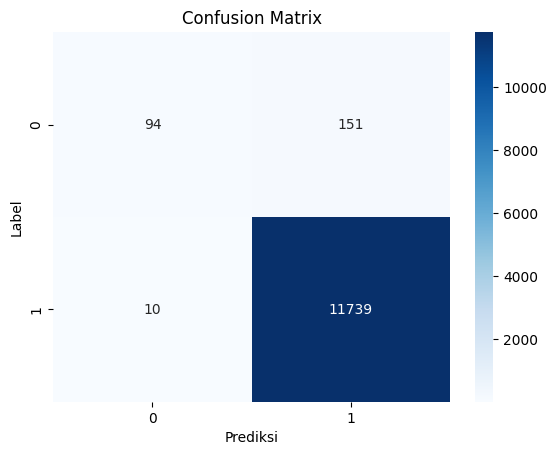

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)

# Menampilkan confusion matrix menggunakan heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.show()

# Testing Prediksi

In [ ]:
nama_fitur = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
              'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
              'FLAG_OWN_CAR_encoded', 'FLAG_OWN_REALTY_encoded', 'NAME_INCOME_TYPE_encoded',
              'NAME_EDUCATION_TYPE_encoded', 'NAME_HOUSING_TYPE_encoded', 'OCCUPATION_TYPE_encoded']

In [ ]:
def input_manual():
    input_data = []

    for fitur in nama_fitur:
        nilai = float(input(f"Masukkan nilai untuk {fitur}: "))
        input_data.append(nilai)

    return np.array([input_data])  # Mengonversi menjadi array 2D untuk satu sampel

def membuat_prediksi(input_data):
    prediksi = model.predict(input_data)
    return prediksi

# Meminta input dari pengguna
input_pengguna = input_manual()

# Melakukan prediksi
hasil_prediksi = membuat_prediksi(input_pengguna)
# Menentukan interpretasi hasil prediksi
interpretasi = "Disetujui" if hasil_prediksi[0] == 1 else "Ditolak"

print("Prediksi:", hasil_prediksi)
print("Hasil:", interpretasi)

Masukkan nilai untuk CNT_CHILDREN: 0
Masukkan nilai untuk AMT_INCOME_TOTAL: 112500.0
Masukkan nilai untuk DAYS_EMPLOYED: -1134
Masukkan nilai untuk FLAG_WORK_PHONE: 0
Masukkan nilai untuk FLAG_PHONE: 0
Masukkan nilai untuk FLAG_EMAIL: 0
Masukkan nilai untuk CNT_FAM_MEMBERS: 2.0
Masukkan nilai untuk FLAG_OWN_CAR_encoded: 1
Masukkan nilai untuk FLAG_OWN_REALTY_encoded: 1
Masukkan nilai untuk NAME_INCOME_TYPE_encoded: 4
Masukkan nilai untuk NAME_EDUCATION_TYPE_encoded: 4
Masukkan nilai untuk NAME_HOUSING_TYPE_encoded: 1
Masukkan nilai untuk OCCUPATION_TYPE_encoded: 18
Prediksi: [1]
Hasil: Disetujui


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
